# Import Modules

In [61]:
import os
import pandas as pd
import numpy as np
from datetime import datetime as dt 
import matplotlib.pyplot as plt
import sklearn
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Data Preprocessing

In [34]:
# Import data from files
os.chdir('/Users/talhajamal/Desktop/Code/BigData1Project')
data = pd.read_csv("data/Returns_Data.csv")
data['date'] = pd.to_datetime(data['date'], dayfirst=False)
characteristics = pd.read_csv("data/Stock_Characteristics_Data.csv")
dictionary = pd.read_excel("data/StockDataDictionary.xlsx")

# Create new dataframes
prices = data.pivot(index='date', columns='ticker', values='PRC')
volume = data.pivot(index='date', columns='ticker', values='VOL')
returns = data.pivot(index='date', columns='ticker', values='RET')
#returns = returns * 100 # Scale returns to percentage
# Summary of Returns
returns_summary = returns.describe()
shares_outstanding = data.pivot(index='date', columns='ticker', values='SHROUT')
value_weighted_returns = data.pivot(index='date', columns='ticker', values='vwretd')
equal_weighted_returns = data.pivot(index='date', columns='ticker', values='ewretd')
tickers = prices.columns # List of Tickers

# Spit Test and Train data
slice_date = dt(year=2018, month=1, day=1)
y_train = returns.loc[:slice_date]
y_test = returns.loc[slice_date:]

# Feature Generation

## Feature 1: On Balance Volume

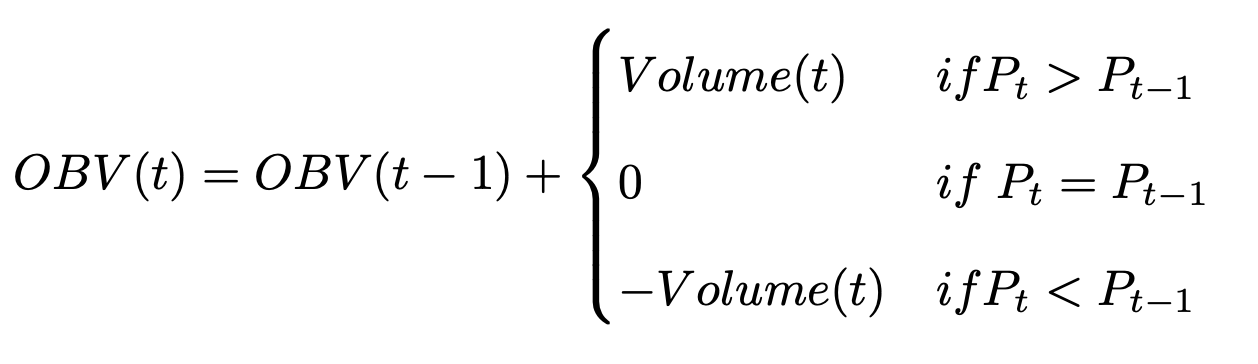

In [35]:
# Feature 1: On Balance Volume
def calculate_obv(stock_returns, stock_volumes):
    """ Function to calculate On Balance Volume"""
    sign = stock_returns.apply(np.sign) # Sign Series: 1 if the return is positive, -1 if negative, 0 if unchanged
    daily_obv_changes = sign * stock_volumes # Daily OBV changes
    obv = daily_obv_changes.cumsum() # Cumulative sum of daily changes
    return obv

# Apply the function to each stock (column)
OBV = returns.apply(lambda col: calculate_obv(col, volume[col.name]), axis=0)

## Feature 2: Stochastic Oscillator %K

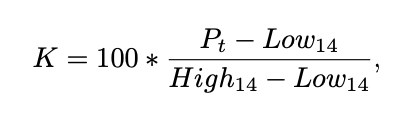

In [36]:
def stochastic_oscillator_k(prices, window):
    low = prices.rolling(window).min()
    high = prices.rolling(window).max()
    K = 100 * ( ( prices - low ) / ( high - low ) )
    return K

stochastic_oscillator = stochastic_oscillator_k(prices, 14)
#stochastic_oscillator.dropna(inplace=True)

## Feature 3: MACD

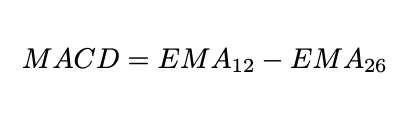

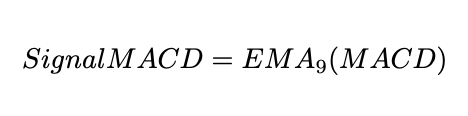

In [37]:
def get_macd(prices, short_period, long_period):
    ema_short = prices.ewm(span=short_period, adjust=False).mean()
    ema_long = prices.ewm(span=long_period, adjust=False).mean()
    return ema_short - ema_long

def get_signal_macd(macd, signal_period):
    signal = macd.ewm(span = signal_period, adjust=False).mean()
    return signal

macd = get_macd(prices, 12, 26)
signal_macd = get_signal_macd(macd, 9)

## Feature 4: 

# XGBoost

In [65]:
xgboost_data = pd.DataFrame(
    {
        'Feature1' : OBV['MSFT'],
        'Feature2' : stochastic_oscillator['MSFT'],
        'Feature3' : macd['MSFT'],
        'Returns Direction' : [1 if x > 0 else 0 for x in returns['MSFT']]
    }
)
xgboost_data.dropna(inplace=True)

In [66]:
xgboost_data

,Feature1,Feature2,Feature3,Returns Direction
date,,,,
2010-01-22,-2.528318e+08,0.000000,-0.235979,0
2010-01-25,-1.892623e+08,16.822430,-0.301213,1
2010-01-26,-1.224777e+08,25.233645,-0.334530,1
2010-01-27,-5.751722e+07,33.177570,-0.343260,1
2010-01-28,-1.753154e+08,9.345794,-0.386871,0
...,...,...,...,...
2020-12-24,9.976457e+08,91.132638,2.243198,1
2020-12-28,1.015543e+09,100.000000,2.545830,1
2020-12-29,9.981632e+08,94.390447,2.689306,0


In [67]:
X = xgboost_data.iloc[:,:-1].values
y = xgboost_data.iloc[:,-1].values

In [68]:
X

array([[-2.52831766e+08,  0.00000000e+00, -2.35979336e-01],
       [-1.89262314e+08,  1.68224299e+01, -3.01212876e-01],
       [-1.22477652e+08,  2.52336449e+01, -3.34530176e-01],
       ...,
       [ 9.98163184e+08,  9.43904471e+01,  2.68930605e+00],
       [ 9.77927402e+08,  7.72851958e+01,  2.57403161e+00],
       [ 9.98844040e+08,  7.82905499e+01,  2.51341532e+00]])

In [69]:
y

array([0, 1, 1, ..., 0, 0, 1])

In [70]:
from sklearn.model_selection import train_test_split # to split the dataset for training and testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2204, 3)
(2204,)
(552, 3)
(552,)


In [72]:
# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [73]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred) * 100
print("Accuracy of the XGBoost Model: ",accuracy)

Accuracy of the XGBoost Model:  65.76086956521739
